In [2]:
%reset -f

import pandas as pd
import os
import re
import numpy as np
from six.moves import xrange
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
origin_data = pd.read_csv('../data/new_all_data.csv')

all_data = origin_data[['day', 'exc_num', 'exc_times', 'front', 'uid']]
all_data.head()

KeyboardInterrupt: 

In [ ]:
# groups = all_data.set_index(['exc_num','day', 'exc_times', 'uid'])
# groups = groups.groupby(by=groups.index)


# cleaned_data = pd.DataFrame()

# offset1 = 0.2
# offset2 = 0

# for index, group in groups:
    
#     tmp = group[['front']][1:] - group[['front']][:-1]
#     tmp = tmp.reset_index()
#     if tmp['front'].min()<-offset1 or tmp['front'].max()>offset1:
#         print(tmp['front'].min(), tmp['front'].max(), tmp['front'].mean())
#         print(len(tmp[tmp['front']>offset1]))
#         print(tmp[tmp['front']>offset1].index)
#         print(index)
#         sns.set_style('whitegrid')
#         f, ax= plt.subplots(figsize = (14, 10))
#         ax = sns.lineplot(x=group[offset:].reset_index().index, y="front", data=group[offset:])
#         ax.set_title(index)
        
        
#     if group['front'].head().mean()> 0.5:
#         exc_num, day, exc_times, uid = index
# #         print(index)
#         sns.set_style('whitegrid')
#         f, ax= plt.subplots(figsize = (14, 10))
#         ax = sns.lineplot(x=group[offset:].reset_index().index, y="front", data=group[offset:])
#         ax.set_title(index)

## 1 Delete outlier according to outlier list from file

### load outliers from file

In [ ]:
outliers = []

with open('../data/figure/deviation_curves_outlier.csv') as f:
    for line in f.readlines():
        tmp = line.split('\n')[0].split(' ')
       
        outliers.append([float(x) for x in tmp])
        

### delete outlier 

In [ ]:
groups = all_data.set_index(['day', 'exc_num', 'exc_times', 'uid'])
groups = groups.groupby(by=groups.index)
origin_groups = origin_data.set_index(['day', 'exc_num', 'exc_times', 'uid'])

new_data = pd.DataFrame()

for index, group in groups:
    if len(group)<10:
        continue
    day, exc_num, exc_times, uid = index
    exc_num = round(exc_num, 1)
    if [day, exc_num, exc_times, uid] in outliers:
        pass
#         tmp = group.reset_index()
#         sns.set_style('whitegrid')
#         f, ax= plt.subplots(figsize = (14, 10))
#         ax = sns.lineplot(x=tmp.index, y="front", data=tmp)
#         ax.set_title(index) 
    else:
        curr = origin_groups.loc[index]
        new_data = pd.concat([new_data, curr], axis=0)

In [ ]:
# new_data.reset_index(drop=False).to_csv('../data/new_data_without_deviation_outlier.csv', index=False)

## 2 Reduce the deviation effect at the start and the end of one experiment 

In [9]:
origin_data = pd.read_csv('../data/new_data_without_deviation_outlier.csv')

all_data = origin_data[['day', 'exc_num', 'exc_times', 'front', 'uid']]
all_data.head()

,day,exc_num,exc_times,front,uid
0,1,1.1,1,0.011647,4
1,1,1.1,1,0.011647,4
2,1,1.1,1,0.011971,4
3,1,1.1,1,0.012333,4
4,1,1.1,1,0.012333,4


In [13]:
def weighted_deviation(data, head=500, has_tail=False):
    
    groups = data.set_index(['day', 'exc_num', 'exc_times', 'uid'])
    groups = groups.groupby(groups.index)
    result = pd.DataFrame(np.array([]).reshape(0,5), columns= ['day', 'exc_num', 'exc_times', 'uid', 'front'])
    
    
    for index,group in groups:
        day, exc_num, exc_times, uid = index
        # the length of header and tailer are equal
        if has_tail:
            assert len(group)>(head*2), 'outlier'
        else:
            assert len(group)>head, 'outlier'

        header = [i+1 for i in xrange(head)]
        if has_tail:
            tailer = header[::-1]
            middle = [head for i in xrange(len(group)-head*2)]
            weights = header.extend(middle.extends(tail))

        else:
            middle = [head for i in xrange(len(group)-head)]

            weights = header+middle
        assert len(group)==len(weights), 'different length between group and weights'
        weights = pd.Series(weights)
        weights = weights/weights.sum()
        avg = (group.reset_index()['front']*weights).sum()
        
        result = result.append({'day':day, 'exc_num':exc_num, 'exc_times':exc_times, 'uid':uid, 
                                'front':avg}, ignore_index=True)
    return result
                   
    
def reduce_header(data, head=500, has_tail=False):
    
    groups = data.set_index(['day', 'exc_num', 'exc_times', 'uid'])
    groups = groups.groupby(groups.index)
    result = pd.DataFrame()
    
    for index, group in groups:
        
        if has_tail:
            assert len(group)>(head*2), 'outlier'
        else:
            assert len(group)>head, 'outlier'
            
        header = [i+1 for i in xrange(head)]
        if has_tail:
            tailer = header[::-1]
            middle = [head for i in xrange(len(group)-head*2)]
            weights = header+middle+tailer

        else:
            middle = [head for i in xrange(len(group)-head)]

            weights = header+middle
            
        weights = pd.Series(weights)    
        weights = weights/head
        assert len(group)==len(weights), 'different length between group and weights'
        curr = group.reset_index()
        curr['front'] =curr['front']*weights
        result = pd.concat([result, curr])
        del curr
        
    return result
                            
# avg = weighted_deviation(all_data)
# avg.head()

reduced_data = reduce_header(all_data,  head=300, has_tail=True)
len(reduced_data)

3214808

In [15]:
reduced_data.head()
reduced_data.to_csv('../data/reduced_header_tailer_data.csv')

In [9]:
avg.describe()

,day,exc_num,exc_times,uid,front
count,708.000000,708.000000,708.000000,708.000000,708.000000
mean,2.974576,2.612853,2.570621,5.735876,0.215601
std,1.441721,1.092234,1.552235,3.225519,0.202369
min,1.000000,1.100000,1.000000,1.000000,0.009969
25%,2.000000,1.500000,1.000000,3.000000,0.091728
50%,3.000000,2.300000,2.000000,6.000000,0.147768
75%,4.000000,3.425000,4.000000,8.000000,0.298303
max,5.000000,4.300000,9.000000,11.000000,2.526412


In [10]:
avg[avg['front']<0.7]
avg.to_csv('../data/avg_without_outlier.csv', index=False)

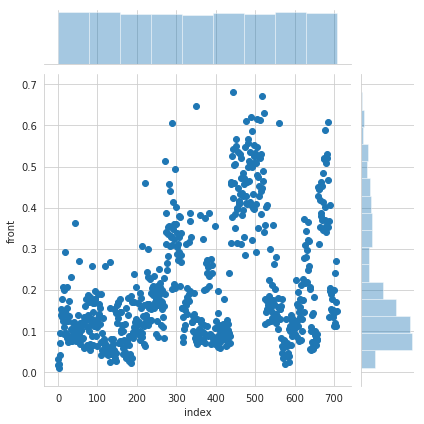

In [11]:
sns.set_style('whitegrid')
# f, ax= plt.subplots(figsize = (14, 10))
ax = sns.jointplot(x='index', y="front", data=avg[avg['front']<0.7].reset_index(drop=False))
# ax.set_title('exc_num is'+str(index))